<h1>Chat Bot</h1>
<h3>This is a basic project about NLP using Keras</h3>

In this project we will be inplementing a sequence to sequence model from scratch that is capable of replying when prompted

Common applications of a well trained NLP model will be:

Eg. ChatGPT, AI chatbot in webpages, Writing elvation tools etc

We will implement this project from scratch and take small steps to ensure understanding.

<h3>Objectives:</h3>

1. Setting up environment
2. LSTM layer and Text classification
    - Dataset seclection
    - Data processing
    - Modeling & Training
    - Deployment
3. Sequence to Sequence(Seq2Seq) modeling, text generation and chatbot
    - Select datasets
    - Dataset processing
    - Modeling & Training
    - Deployment



**<h3>Section 1: Setting Up Environment</h3>**

**For this project, we are using Python 3.11.7, aloneside with the following packages:**

1. os
2. yaml
3. keras = ^2.15.0
4. tensorflow = ^2.15.0
5. tensorflow_text = ^2.15.0
6. numpy = ^1.26.3

**Use !pip install (package_name) if you do not have the packages**

In [2]:
import numpy as np
import tensorflow as tf
import keras
import os
import yaml
from keras.datasets import imdb

<h3>Section 2: LSTM Layer & Text classification</h3>

**In this section, we will explore the basic text sentiment classification task and explore the effect of Long Short Term Memory when dealing with text data**

**<h4>Section 2.1: Data Selection</h4>**

**For this task, we choose the IMBD dataset from keras** 

**IMBD is a preprocessed dataset containing mixed, labeled movie reviews, perfect for learning**

**It contains 88584 unique words and those words form a vocabulary library, which is crucial for tokenising, a preprocessing technique that encodes text data into integer. which we will discuss more in section 3**

In [31]:
SEN_VOCAB_SIZE = len(imdb.get_word_index()) #Check the size of the vocabulary, it is 88584
MAXLEN = 250
BATCH_SIZE = 64

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = SEN_VOCAB_SIZE, index_from=3)

**Let us take a look at the training data, as we can see, the data is already tokenised**

In [33]:
train_data[0]


[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

**To view the origincal text, we need a decode function**

**In this function, we will refer the integer index to the dictionary provided by the imdb dataset and return the corresponding words**

In [41]:
Vocabularies = imdb.get_word_index()
Vocabularies = {k:(v+3) for k,v in Vocabularies.items()} #Shift the index of the words by 3 to make space for special characters, as imdb dataset start its indexing from 3
Vocabularies["<PAD>"] = 0

def decoder(text):
    reverse_word_index = dict([(value, key) for (key, value) in Vocabularies.items()]) #Reverse the word index
    decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in text if i != 0]) #Decode the review. If the word is not in the index, replace it with ?
    print(decoded_review)
    
decoder(train_data[0])

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

**<h4>Section 2.2: Data Processng</h4>**

**Since the dataset is already cleaned and preprocessed, there are minimal steps to do**

**We just have to pad all the train and test datas by adding 0s behind to make sure that everything fed to the neural network is the same shape**

In [5]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, MAXLEN, padding='post')
test_data = keras.preprocessing.sequence.pad_sequences(test_data, MAXLEN, padding='post')

**<h4>Section 2.3: Modeling and Training</h4>**

**Since the dataset is relatively small, we will try with a simple neural network**

**In the sequential model, we need an embeding layer to represent the tokenised words into real valued vectors, this allows similar words to have a similar magnitude and direction**

**Then we need a Long Short Term Memory Layer to remember the occurance and sequence of words appearing**

**And finally a dense layer to output our binary prediction**

In [5]:
model = keras.Sequential([
    keras.layers.Embedding(SEN_VOCAB_SIZE, 32),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          2834688   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2843041 (10.85 MB)
Trainable params: 2843041 (10.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can visualise our model to get a better insight

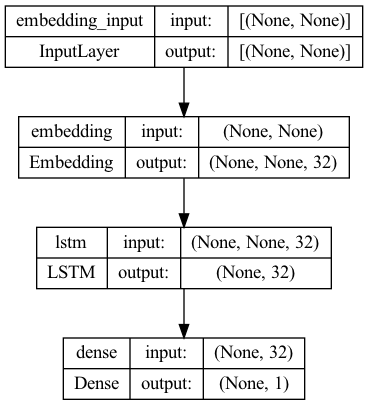

In [6]:
keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=['acc'])


**Unlike image classification, we do not have all the preprocessing techniques like augmentations to help with overfitting**

**Thus to prevent overfitting, we will be introducing an early stopping criteria. In this case, we will stop the training if the validation loss no longer decreases for 3 consecetive episodes** 

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_loss',
    restore_best_weights=True,
)
history = model.fit(train_data, train_labels, epochs=10, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/10
547/547 [==============================] - 15s 27ms/step - loss: 0.6592 - acc: 0.5965 - val_loss: 0.4908 - val_acc: 0.7992
Epoch 2/10
547/547 [==============================] - 15s 27ms/step - loss: 0.4814 - acc: 0.8048 - val_loss: 0.4080 - val_acc: 0.8451
Epoch 3/10
547/547 [==============================] - 15s 27ms/step - loss: 0.3668 - acc: 0.8721 - val_loss: 0.3568 - val_acc: 0.8620
Epoch 4/10
547/547 [==============================] - 15s 27ms/step - loss: 0.2977 - acc: 0.8992 - val_loss: 0.3475 - val_acc: 0.8747
Epoch 5/10
547/547 [==============================] - 15s 27ms/step - loss: 0.2558 - acc: 0.9094 - val_loss: 0.3109 - val_acc: 0.8707
Epoch 6/10
547/547 [==============================] - 16s 28ms/step - loss: 0.2347 - acc: 0.9127 - val_loss: 0.5094 - val_acc: 0.8520
Epoch 7/10
547/547 [==============================] - 15s 28ms/step - loss: 0.2156 - acc: 0.9273 - val_loss: 0.3473 - val_acc: 0.8743
Epoch 8/10
547/547 [==============================] - 15s 27ms

In [35]:
model.save("sentiment_model.keras")

**<h4>Section 2.4: Deployment</h4>**

**Now that we have trained our model, it is time to put the model into test**

**In order to use our model for prediction, we must first process our inputs by tokenising them and pad them to correct length**

**Using the same vocabularies that we get earlier, we can tokenise our inputs by replacing each word with its integer index in the vocabularies**

In [42]:
def encode_text(text):
  tokens = keras.preprocessing.text.text_to_word_sequence(text)
  tokens = [Vocabularies[word] if word in Vocabularies else 0 for word in tokens]
  return keras.preprocessing.sequence.pad_sequences([tokens], MAXLEN, padding="post")[0]

text = "that movie was just amazing, so amazing"
encoded = encode_text(text)
print(encoded)

[ 15  20  16  43 480  38 480   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

**We can view our encoded text with the same decoder that we have defined just now**

In [43]:
decoder(encoded)

that movie was just amazing so amazing


**Lastly we need a prediction function to predict the sentiment of the review**

**Since our neural network only outputs 1 input, it represent the confidence of the model on whether the review is positive**

**Therefore if the output result is more than 0.5, we will conclude that the model predicts the review to be positive and vice versa**

In [12]:
def predict(text):
  encoded_text = encode_text(text)
  pred = np.zeros((1,250))
  pred[0] = encoded_text
  result = model.predict(pred) 
  if result[0] > 0.5:
    print("Positive")
  else:
    print("Negative")

positive_review = "I thought the movie was going to be bad, but it was actually great!"
predict(positive_review)

negative_review = "that movie really sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"
predict(negative_review)

1/1 [==============================] - 0s 12ms/step
Positive
1/1 [==============================] - 0s 11ms/step
Negative


<h3>Section 3: Sequence to Sequence Modeling, text generation and chatbot</h3>

**Now that we are more or less clear with word embedding and LSTM layer, let us dive deeper to understand another concept**

**Text generation is basically predicting the next probable word given base on the memory and current word** 

**Chat bot is but a word continuation that takes in additional context from question input**

**In this section we will be exploring a more advance concept called Sequence to Sequence modeling to build our chatbot**

**<h4>Section 3.1: Selecting Datasets</h4>**

**For the training dataset, we will be using the chatterbot/english dataset on Kaggle.com by kausr25**

**ALternatively, we can run the below cells to get the raw data from github**

In [43]:
# !wget https://github.com/shubham0204/Dataset_Archives/blob/master/chatbot_nlp.zip?raw=true -O chatbot_nlp.zip
# !unzip chatbot_nlp.zip

**<h4>Section 3.2: Data Processing</h4>**

**Let us start by loading our datasets.** 

**Since we downloaded the datasets into our local machine, we need the help of os to navigate around our files**

In [9]:
dir_path = 'chatbot_nlp/data'
files_list = os.listdir(dir_path + os.sep) # os.sep adds the separator for the file path, we are getting a list of all the yaml files in the directory

questions = list()
answers = list()

for filepath in files_list:
    stream = open(dir_path + os.sep + filepath , 'rb')  #We are opening the file in read binary mode
    docs = yaml.safe_load(stream)   #yaml.safe_load() is used to load the data from the yaml file
    conversations = docs['conversations'] #To get the conversations from the yaml file
    
    #In the case of robots replying in more than sentences, we are combining them into one sentence
    for con in conversations:
        if len(con) > 2 :
            questions.append(con[0])
            replies = con[1: ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            questions.append(con[0])
            answers.append(con[1])

#Visualises the questions and answers
print(questions[:5])
print(answers[:5])

['have you read the communist', 'what is a government', 'what is greenpeace', 'what is capitalism', 'what is socialism']
['yes, marx had made some interesting observations.', 'ideally it is a representative of the people.', 'global organization promoting enviornmental activism.', 'the economic system in which all or most of the means of production and distribution, as land, factories, railroads, etc., are privately owned and operated for profit, originally under fully competitive conditions.', 'communism from people who want to keep their volvos. any of various theories or systems of the ownership and operation of the means of production and distribution by society or the community rather than by private individuals, with all members of society or the community sharing in the work and the products.']


**For the purpose of smoothing training, we want to remove the question and answer pairs that the answer is too short**

In [10]:
proper_answers = list()
for i in range(len(answers)):
    if type(answers[i]) == str:
        proper_answers.append(answers[i])
    else:
        questions.pop(i)
        
print(proper_answers[:5])

['yes, marx had made some interesting observations.', 'ideally it is a representative of the people.', 'global organization promoting enviornmental activism.', 'the economic system in which all or most of the means of production and distribution, as land, factories, railroads, etc., are privately owned and operated for profit, originally under fully competitive conditions.', 'communism from people who want to keep their volvos. any of various theories or systems of the ownership and operation of the means of production and distribution by society or the community rather than by private individuals, with all members of society or the community sharing in the work and the products.']


**We should also add a start and end token to our answers and the machine can use those as indications whether a sentence has started or ended**

In [11]:
answers = list()
for i in range(len(proper_answers)) :
    answers.append('<START>' + proper_answers[i] + '<END>')

print(answers[:5])

['<START>yes, marx had made some interesting observations.<END>', '<START>ideally it is a representative of the people.<END>', '<START>global organization promoting enviornmental activism.<END>', '<START>the economic system in which all or most of the means of production and distribution, as land, factories, railroads, etc., are privately owned and operated for profit, originally under fully competitive conditions.<END>', '<START>communism from people who want to keep their volvos. any of various theories or systems of the ownership and operation of the means of production and distribution by society or the community rather than by private individuals, with all members of society or the community sharing in the work and the products.<END>']


**In order to pass the text data into the neural network for training, we have to convert them into numbers**

**Luckily, keras do provide a tokeniser function to do the job for us**

**Tokeniser works by refering a word passed into it to a vocabulary list and returns the indices of the word in the list**

**For example, if the tokeniser have a vocabulary [let's, us, go, above, higher]. The string "Let's go higher" passed into the tokeniser will generate return [0,2,4]**

**To use the tokeniser, first we need to generate a vocabulary list by including every word appeared in all question and answer pairs**

In [12]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(questions+answers)
VOCAB_SIZE = len(tokenizer.word_index)+1
print(f"Vocab size: {VOCAB_SIZE}")

vocab = []
for word in tokenizer.word_index:
    vocab.append(word)

Vocab size: 1894


**Now that we have our tokenisers ready, we can start to tokenise every questions and answers**

**Since neural networks prefers to accept identical shapes of input, we will pad all questions to the longest questions in the dataset**

**The term encoder_input_data will be explained later**

In [13]:
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = keras.preprocessing.sequence.pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data[:5])

[[ 18   3  78   6 782   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 10   7   4 346   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 10   7 783   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 10   7 784   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 10   7 785   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


**Similarly for answers, we will pad all answers to the longest answer in the dataset**

**We need to tokenise the answers twice, one is used as label for our training and the other one will be our guided input. This will be further explained later as well. The 2 sequences are only offsetted by 1 position**

In [14]:
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = keras.preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print(decoder_input_data[:5])


for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = keras.preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post' )
print(padded_answers[:5])
onehot_answers = keras.utils.to_categorical(padded_answers, VOCAB_SIZE) #Since the output is going to be our label, we are one hot encoding it to make it categorical
decoder_output_data = np.array(onehot_answers)
print(decoder_output_data[:5])


[[  2 105 949 399 138 101 400 950   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2 951  16   7   4 952   8   6 115   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2 953 566 954 955 956   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2   6 567 201  17  52  47  38 297   8   6 298   8 299  14 401  22 957
  958

**<h4>Section 3.3: Modeling and Training</h4>**

**We need a sequence to sequence model for this task, it consists of an encoder and a decoder**

**The encoder will take the input and the decoder will produce the output**

**The encoder will produce a context vector which will be used by the decoder to produce the output**

**The context vector is the final hidden state of the encoder**

**The decoder takes in both the context vector and the previously generated words to generate subsequent words, you can see it like a text continuation**

**This is the reason why we need to tokenise the answers twice for training**

**Both the encoder and decoder utilises embdedding layers as well as LSTM layers to estimate the context of words relative to its position**

**Finally the output of the decoder will be connected to a dense layer to produce the outcome and compare with the label**

In [15]:
encoder_inputs = tf.keras.layers.Input(shape=(maxlen_questions, )) #We set the input shape of the encoder to the max length of the input data which we padded to
encoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200, mask_zero=True) (encoder_inputs) 
encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(200, return_state=True)(encoder_embedding) #We'll have the LSTM to return a 200 dimensional output and the hidden and cell states as the neural network resurses
encoder_states = [state_h, state_c] #The combined hidden and cell states of the encoder is the context vector which we will use in the decoder

decoder_inputs = tf.keras.layers.Input(shape=(maxlen_answers,  )) #similarly, set the input shape of the decoder to the max length of the input data which we padded to
decoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200, mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(200, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states) #The initial state of this decoder will be the context vector generated, and we are no longer interested in the hidden and cell states of the decoder, only the output.
decoder_dense = tf.keras.layers.Dense(VOCAB_SIZE, activation=tf.keras.activations.softmax) 
output = decoder_dense (decoder_outputs) #The output of the decoder will be a dense layer with a softmax activation, which will output a one hot encoded vector of the predicted word

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 22)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 74)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 22, 200)              378800    ['input_1[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 74, 200)              378800    ['input_2[0][0]']             
                                                                                              

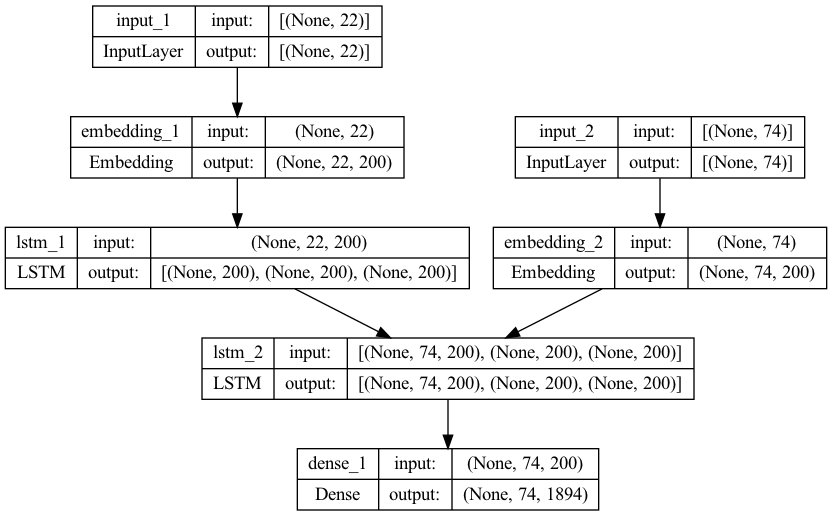

In [16]:
keras.utils.plot_model(model, show_shapes=True)

**Since the dataset is small and there are not alot of parameters to train, let us try to fit the model with a batch size of 16 and epoch number of 150**

In [41]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=16, epochs=150) 
model.save('model.keras')  

Epoch 1/150
36/36 [==============================] - 5s 61ms/step - loss: 6.2065
Epoch 2/150
36/36 [==============================] - 2s 63ms/step - loss: 5.5191
Epoch 3/150
36/36 [==============================] - 2s 68ms/step - loss: 5.3021
Epoch 4/150
36/36 [==============================] - 2s 62ms/step - loss: 5.1835
Epoch 5/150
36/36 [==============================] - 2s 67ms/step - loss: 5.0494
Epoch 6/150
36/36 [==============================] - 2s 69ms/step - loss: 4.8927
Epoch 7/150
36/36 [==============================] - 3s 70ms/step - loss: 4.7339
Epoch 8/150
36/36 [==============================] - 3s 73ms/step - loss: 4.5996
Epoch 9/150
36/36 [==============================] - 2s 68ms/step - loss: 4.4785
Epoch 10/150
36/36 [==============================] - 2s 69ms/step - loss: 4.3488
Epoch 11/150
36/36 [==============================] - 2s 68ms/step - loss: 4.2530
Epoch 12/150
36/36 [==============================] - 3s 70ms/step - loss: 4.1097
Epoch 13/150
36/36 [=====

/Users/chenyijie/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**<h4> Section 3.4: Deployment</h4>**

**To use our trained network to predict the answer to a question. We have to restructure the model as now we do not have a completed answer to input into the decoder model but only the start token and encoder states.**

**We basically need our decoder to feed it's own output as the inputs for next step**

In [45]:
def make_inference_models():
    
    #First we define the encoder model, which takes in a tokenised question as input, and outputs the hidden state and cell state
    #The hidden states are given by the embedding layer, and the cell states are given by the LSTM layer which we trained earlier
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    #Next we define the input data for the decoder model, which is the encoder states output by the encoder model. It is of sized 200 as specified by our encoder LSTM layer
    decoder_state_input_h = tf.keras.layers.Input(shape=(200, ))
    decoder_state_input_c = tf.keras.layers.Input(shape=(200, ))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    #The output of the decoder model is given by the trained LSTM layer, which takes in the output of embedding layer which we trained earlier and the encoder states as inputs
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    #Finally we define the decoder model, which takes in the decoder inputs and the encoder states, and outputs the decoder outputs and the decoder states
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
    
    return encoder_model , decoder_model

**Finally, we define a functions that processes the human input, making it of suitable size for prediction**

In [46]:
#To process a input, we define a function that tokenises the string input, and then pads it to the maximum length of the questions
def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append(tokenizer.word_index[word]) 
    return keras.preprocessing.sequence.pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post')

**Time to take the chatbot to a real test!**

**We can see that the chatbot have a decent accuracy in replying questions. GOod job!**

In [144]:
enc_model , dec_model = make_inference_models()

#Our model is now trained and we can use it to build a mini chatbot!
#We can now use the encoder model to get the encoder states for a given question, and then use the decoder model to get the answer

# states_values = enc_model.predict(str_to_tokens(input('Enter question : ')), verbose=0)
states_values = enc_model.predict(str_to_tokens('can you move'), verbose=0) #Use the previous line to ask for an input when deploying the model
decoder_start_seq = np.zeros((1,1))
decoder_start_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''

#We will loop through the decoder predictions and apped the word into a list until we reach the end token or the maximum length of the answer
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([decoder_start_seq] + states_values, verbose=0) 
    sampled_word_index = np.argmax(dec_outputs[0, -1, :]) #This replaces the dense layer in our previous model and returns the index of the word with the highest probability
    sampled_word = None
    for word, index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format(word) #Append the word generated to the decoded translation
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
        stop_condition = True
    
    #We will update the decoder input to the word we just predicted, and update the states values to the new states    
    decoder_start_seq = np.zeros((1 , 1))  
    decoder_start_seq[0, 0] = sampled_word_index #Update the decoder input to the word we just predicted
    states_values = [h, c] 

print(decoded_translation)


 sorry my body isn't built just yet i reside only here for now end
